### Прогнозирование оттока клиентов
##### Суть бизнес задачи:
Каждый год компания пролонгирует полисы Каско клиентов - физических лиц. Для оптимизации работы со списками на пролонгацию необходимо прогнозировать с какой вероятностью каждый из клиентов пролонгируется и какие факторы на это влияют. В зависимости от этого расставляются приоритеты операторам колл-центра, которые обрабатывают список (осуществляют обзвон клиентов), а также принимаются решения по дополнительной мотивации клиентов к пролонгации.
 
##### Описание массива:
Дана выборка полисов на пролонгацию в формате CSV-файла с набором полей, характеризующих сам полис, клиента (и его историю страхования) и транспортное средство. Полис на пролонгацию – это полис, период действия заканчивается и который нужно пролонгировать.
Прогнозируемая переменная – факт пролонгации полиса «POLICY_IS_RENEWED», где «1» – клиент пролонгировался, «0» - клиент не пролонгировался.
Массив случайным образом разбит на 2 части: 80% данных – тренировочная выборка, 20% данных – тестовая выборка.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
from pandas import set_option
from sklearn import preprocessing
set_option("display.max_rows", 10)
pd.options.mode.chained_assignment = None

Загружаем и смотрим на данные

In [2]:
filename = 'data.txt'
data = pd.read_csv(filename, sep = ';')
data.head()

,DATA_TYPE,POLICY_ID,POLICY_BEGIN_MONTH,POLICY_END_MONTH,POLICY_IS_RENEWED,POLICY_SALES_CHANNEL,POLICY_SALES_CHANNEL_GROUP,POLICY_BRANCH,POLICY_MIN_AGE,POLICY_MIN_DRIVING_EXPERIENCE,...,POLICY_PRV_CLM_GLT_N,CLIENT_HAS_DAGO,CLIENT_HAS_OSAGO,POLICY_COURT_SIGN,CLAIM_AVG_ACC_ST_PRD,POLICY_HAS_COMPLAINTS,POLICY_YEARS_RENEWED_N,POLICY_DEDUCT_VALUE,CLIENT_REGISTRATION_REGION,POLICY_PRICE_CHANGE
0,TRAIN,1,1,1,1,39,1,Москва,51,12,...,N,1,0,0,0.0,0,0,0.0,Тульская,-1.00
1,TRAIN,2,1,1,1,50,5,Москва,35,7,...,0,1,1,0,0.0,0,4,0.0,Москва,-0.05
2,TRAIN,3,1,1,1,52,6,Москва,41,6,...,1L,0,0,0,0.0,0,1,12518.0,Московская,-0.07
3,TRAIN,4,1,1,1,50,5,Москва,36,12,...,0,1,1,0,0.0,0,6,15000.0,Москва,0.05
4,TRAIN,5,1,1,0,52,6,Санкт-Петербург,42,5,...,N,0,0,0,0.0,0,0,50000.0,Ленинградская,0.17


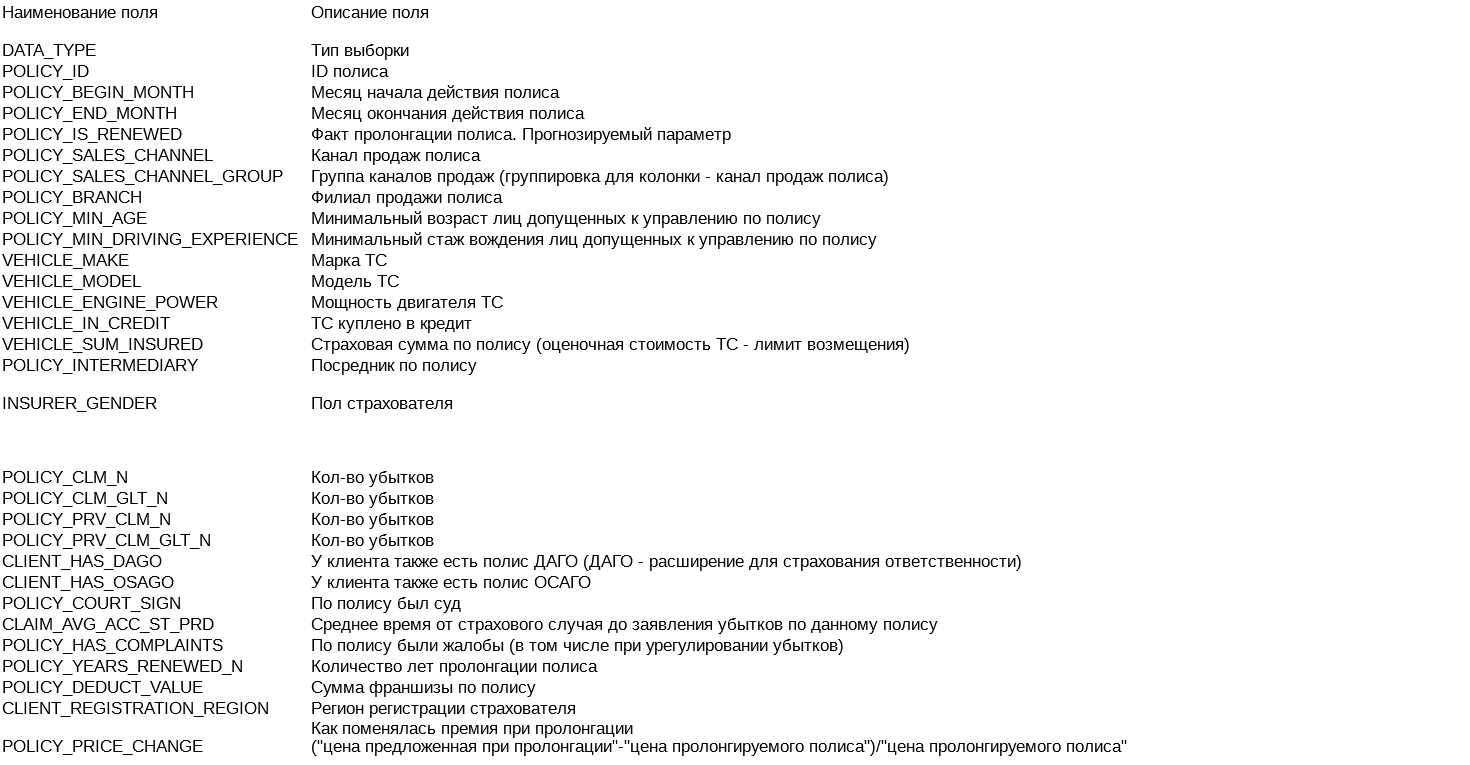

Разделим признаки по типу

In [3]:
data = data.drop(['POLICY_ID','POLICY_END_MONTH'], 1)
numeric_cols = ['POLICY_MIN_AGE', 'POLICY_MIN_DRIVING_EXPERIENCE', 'VEHICLE_ENGINE_POWER',
                'VEHICLE_SUM_INSURED', 'CLAIM_AVG_ACC_ST_PRD', 
                'POLICY_DEDUCT_VALUE', 'POLICY_PRICE_CHANGE']
categorical_cols = list(set(data.columns.values.tolist()) - set(numeric_cols))
categorical_cols.remove('DATA_TYPE')
categorical_cols.remove('POLICY_IS_RENEWED')

Преобразование категориальных признаков

In [4]:
# преобразуем категории в числа
# преобразуем убытки
damages = ['POLICY_CLM_N', 'POLICY_CLM_GLT_N','POLICY_PRV_CLM_N', 'POLICY_PRV_CLM_GLT_N']
for column in damages:
    data[column][data[column] == '0'] = 0
    data[column][data[column] == 'n/d'] = 0
    data[column][data[column] == 'N'] = 0
    
    data[column][data[column] == '1S'] = 1
    data[column][data[column] == '1L'] = 2
    data[column][data[column] == '2'] = 3
    data[column][data[column] == '3'] = 4
    data[column][data[column] == '4+'] = 5
    data[column] = data[column].astype(int)   
    categorical_cols.remove(column)

In [5]:
# количество лет пролонгации
data['POLICY_YEARS_RENEWED_N'][data['POLICY_YEARS_RENEWED_N'] == 'N'] = 0
categorical_cols.remove('POLICY_YEARS_RENEWED_N')
data['POLICY_YEARS_RENEWED_N'] = data['POLICY_YEARS_RENEWED_N'].astype(int)

In [6]:
# заменяем каждую категорию числом входящих в неё объектов
def num_feature(column):
    items = list(set(data[column]))
    for item in items:
        data[column][data[column] == item] = len(data[data[column] == item])
    data[column] = data[column].astype(int)
    categorical_cols.remove(column)
    

In [7]:
# модель и марка авто
num_feature('VEHICLE_MODEL')
num_feature('VEHICLE_MAKE')
# регион регистрации
num_feature('CLIENT_REGISTRATION_REGION')
# канал продаж
num_feature('POLICY_SALES_CHANNEL')
num_feature('POLICY_SALES_CHANNEL_GROUP')
# посредник
num_feature('POLICY_INTERMEDIARY')

In [8]:
# оставшиеся категориальные признаки
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
for col in categorical_cols:
    d=data[col]
    le.fit(d.values)
    data[col]=le.transform(data[col])

Посмотрим что получилось

In [9]:
data.head()

,DATA_TYPE,POLICY_BEGIN_MONTH,POLICY_IS_RENEWED,POLICY_SALES_CHANNEL,POLICY_SALES_CHANNEL_GROUP,POLICY_BRANCH,POLICY_MIN_AGE,POLICY_MIN_DRIVING_EXPERIENCE,VEHICLE_MAKE,VEHICLE_MODEL,...,POLICY_PRV_CLM_GLT_N,CLIENT_HAS_DAGO,CLIENT_HAS_OSAGO,POLICY_COURT_SIGN,CLAIM_AVG_ACC_ST_PRD,POLICY_HAS_COMPLAINTS,POLICY_YEARS_RENEWED_N,POLICY_DEDUCT_VALUE,CLIENT_REGISTRATION_REGION,POLICY_PRICE_CHANGE
0,TRAIN,0,1,451,9860,0,51,12,1674,264,...,0,1,0,0,0.0,0,0,0.0,219,-1.00
1,TRAIN,0,1,16176,16176,0,35,7,1789,187,...,0,1,1,0,0.0,0,4,0.0,34420,-0.05
2,TRAIN,0,1,24728,62093,0,41,6,11050,324,...,2,0,0,0,0.0,0,1,12518.0,12820,-0.07
3,TRAIN,0,1,16176,16176,0,36,12,342,75,...,0,1,1,0,0.0,0,6,15000.0,34420,0.05
4,TRAIN,0,0,24728,62093,1,42,5,8733,802,...,0,0,0,0,0.0,0,0,50000.0,5877,0.17


Обучаем модель

In [10]:
test_data = data[data['DATA_TYPE'] != 'TRAIN']
training_data = data[data['DATA_TYPE'] == 'TRAIN']

In [11]:
from sklearn.utils import shuffle
training_data = shuffle(training_data)

X = training_data.drop(['POLICY_IS_RENEWED', 'DATA_TYPE'], 1)
y = training_data['POLICY_IS_RENEWED']
X_blind = test_data.drop(['POLICY_IS_RENEWED', 'DATA_TYPE'], 1)
y_blind = test_data['POLICY_IS_RENEWED']

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [14]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator
from sklearn.metrics import f1_score, recall_score, accuracy_score, confusion_matrix
from xgboost import XGBClassifier
from sklearn.preprocessing import FunctionTransformer
from copy import copy

clf = make_pipeline(
    make_union(
        FunctionTransformer(copy),
        FunctionTransformer(copy)
    ),
    XGBClassifier(learning_rate=0.1, max_depth=4, min_child_weight=8, n_estimators=100, nthread=1, subsample=0.6000000000000001)
)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
f1 = f1_score(y_test, y_pred)
f1

0.79576029351814104

Предсказания

In [15]:
clf.fit(X, y)
y_pred = clf.predict(X_blind)
y_proba = clf.predict_proba(X_blind)

In [16]:
predict = pd.DataFrame({'POLICY_ID':y_blind.index, 'POLICY_IS_RENEWED': y_pred, 'POLICY_IS_RENEWED_PROBABILITY': y_proba[:,1]})
predict                      

,POLICY_ID,POLICY_IS_RENEWED,POLICY_IS_RENEWED_PROBABILITY
0,9,1,0.842963
1,11,1,0.716241
2,12,1,0.712546
3,21,0,0.361118
4,36,1,0.818060
...,...,...,...
19193,96573,1,0.810549
19194,96576,1,0.527095
19195,96585,1,0.880807
19196,96594,1,0.681704


In [17]:
predict.to_csv('predict.csv')